In [2]:
# colab cell 1
!pip install -q pandas scikit-learn nltk matplotlib gradio joblib


In [3]:
# colab cell 2
import pandas as pd
df = pd.read_csv("comments_dataset.csv")
print("Rows:", len(df))
display(df.head(10))
df['label'].value_counts()


Rows: 175


,comment,label
0,Amazing work! Loved the animation.,Praise
1,"This is beautiful, great job!",Praise
2,Loved the editing!,Praise
3,Brilliant animation style!,Praise
4,"Top-quality work, impressive!",Praise
5,So clean and smooth!,Praise
6,This deserves way more views!,Praise
7,Masterpiece!,Praise
8,Absolutely stunning visuals!,Praise
9,Incredible attention to detail!,Praise


,count
label,
Praise,25
Support,25
Constructive Criticism,25
Hate/Abuse,25
Emotional,25
Spam,25
Question/Suggestion,15
Threat,10


In [11]:
# colab cell 3
import re
import nltk
# Required downloads for latest NLTK
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')  # ← NEW REQUIRED
nltk.download('omw-1.4')

from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str):
        text = str(text)

    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"@\w+|#\w+", "", text)
    text = re.sub(r"[^a-z0-9\s']", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    return wordnet.NOUN

def tokenize_and_lemmatize(text):
    text = clean_text(text)
    tokens = nltk.word_tokenize(text)

    tokens = [t for t in tokens if t not in STOPWORDS]

    pos_tags = nltk.pos_tag(tokens, lang='eng')

    lemmatized = [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag))
        for word, tag in pos_tags
    ]

    return " ".join(lemmatized)

print(tokenize_and_lemmatize("Amazing work! Loved the animation."))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


amazing work love animation


[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [5]:
# Colab cell 4
# create label map
labels = sorted(df['label'].unique())
label2id = {lab: i for i, lab in enumerate(labels)}
id2label = {i: lab for lab, i in label2id.items()}

print("Labels:", label2id)

# preprocess comments
df['text_clean'] = df['comment'].astype(str).apply(tokenize_and_lemmatize)
df['label_id'] = df['label'].map(label2id)

# quick sample
display(df[['comment','text_clean','label','label_id']].head(8))


Labels: {'Constructive Criticism': 0, 'Emotional': 1, 'Hate/Abuse': 2, 'Praise': 3, 'Question/Suggestion': 4, 'Spam': 5, 'Support': 6, 'Threat': 7}


,comment,text_clean,label,label_id
0,Amazing work! Loved the animation.,amazing work love animation,Praise,3
1,"This is beautiful, great job!",beautiful great job,Praise,3
2,Loved the editing!,love editing,Praise,3
3,Brilliant animation style!,brilliant animation style,Praise,3
4,"Top-quality work, impressive!",top quality work impressive,Praise,3
5,So clean and smooth!,clean smooth,Praise,3
6,This deserves way more views!,deserves way view,Praise,3
7,Masterpiece!,masterpiece,Praise,3


In [6]:
# Colab cell 5
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

X = df['text_clean'].tolist()
y = df['label_id'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=20000)),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

print("Training...")
pipeline.fit(X_train, y_train)
print("Done.")


Training...
Done.


Classification report:
                        precision    recall  f1-score   support

Constructive Criticism       0.67      0.50      0.57         4
             Emotional       1.00      0.25      0.40         4
            Hate/Abuse       1.00      0.25      0.40         4
                Praise       0.60      0.75      0.67         4
   Question/Suggestion       0.50      0.50      0.50         2
                  Spam       0.33      0.75      0.46         4
               Support       0.20      0.25      0.22         4
                Threat       0.00      0.00      0.00         1

              accuracy                           0.44        27
             macro avg       0.54      0.41      0.40        27
          weighted avg       0.60      0.44      0.44        27

Confusion matrix:
 [[2 0 0 0 1 0 1 0]
 [0 1 0 0 0 3 0 0]
 [0 0 1 1 0 1 1 0]
 [0 0 0 3 0 0 1 0]
 [1 0 0 0 1 0 0 0]
 [0 0 0 0 0 3 1 0]
 [0 0 0 1 0 1 1 1]
 [0 0 0 0 0 1 0 0]]


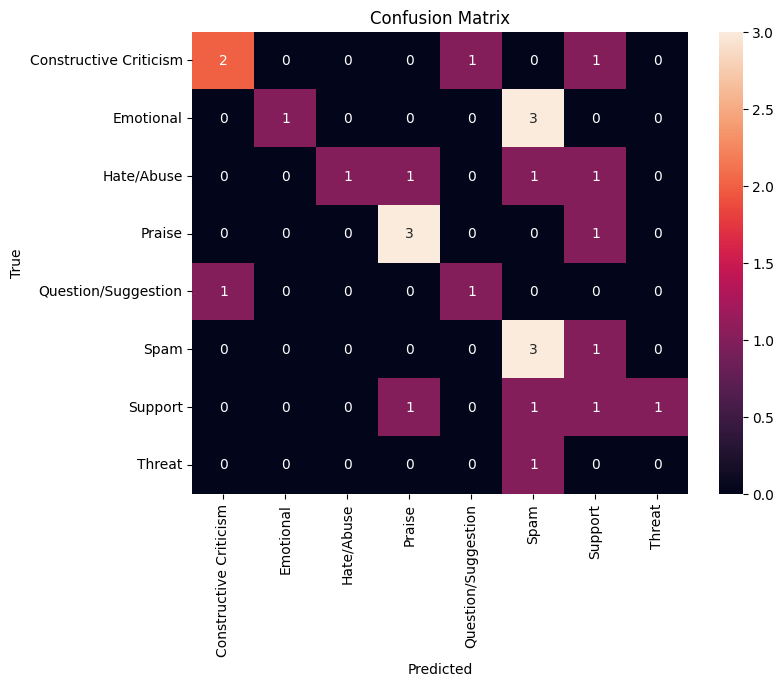

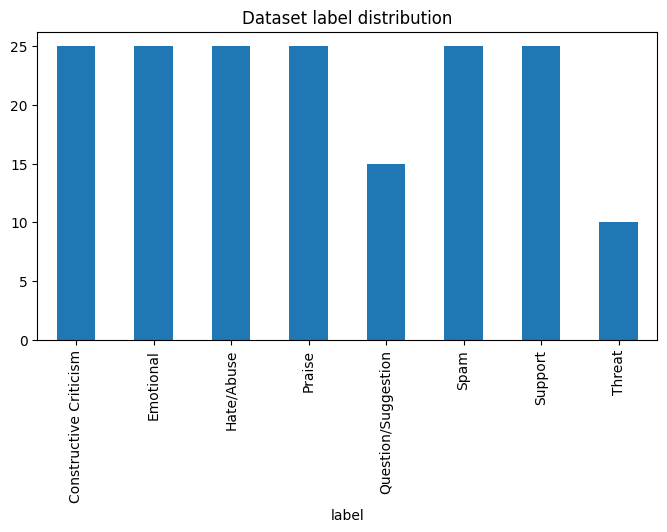

In [7]:
# Colab cell 6
import numpy as np
y_pred = pipeline.predict(X_test)

print("Classification report:")
print(classification_report(y_test, y_pred, target_names=[id2label[i] for i in sorted(id2label)]))

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

# plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=[id2label[i] for i in sorted(id2label)], yticklabels=[id2label[i] for i in sorted(id2label)])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# category counts (for distribution)
full_counts = df['label'].value_counts().sort_index()
plt.figure(figsize=(8,4))
full_counts.plot(kind='bar')
plt.title("Dataset label distribution")
plt.show()


In [8]:
# Colab cell 7
import joblib
joblib.dump(pipeline, "tfidf_lr_model.pkl")
joblib.dump(label2id, "label2id.pkl")
joblib.dump(id2label, "id2label.pkl")
print("Saved: tfidf_lr_model.pkl, label2id.pkl, id2label.pkl")


Saved: tfidf_lr_model.pkl, label2id.pkl, id2label.pkl


In [9]:
# Colab cell 8
# load back (just to show usage)
model = joblib.load("tfidf_lr_model.pkl")
id2label = joblib.load("id2label.pkl")

# predict on whole dataset
df['pred_id'] = model.predict(df['text_clean'].tolist())
df['pred_label'] = df['pred_id'].map(id2label)

# simple reply templates map (you can customize)
reply_templates = {
    "Praise": ["Thanks so much! 😊 We’re thrilled you enjoyed it."],
    "Support": ["Thanks for the encouragement — it keeps us going!"],
    "Constructive Criticism": ["Thanks for the feedback — could you tell us which part you mean so we can improve?"],
    "Hate/Abuse": ["We’re sorry you feel that way. Please keep feedback respectful."],
    "Threat": ["We take safety seriously. Please contact support@example.com to escalate."],
    "Emotional": ["Thank you for sharing — we’re glad it resonated with you."],
    "Spam": ["This comment appears promotional and may be removed according to our policy."],
    "Question/Suggestion": ["Great question/suggestion — we’ll consider it!"]
}

# map reply
def get_reply(pred_label):
    return reply_templates.get(pred_label, ["Thanks for your comment."])[0]

df['suggested_reply'] = df['pred_label'].apply(get_reply)

# save categorized CSV
df.to_csv("categorized_comments_with_replies.csv", index=False)
print("Saved categorized_comments_with_replies.csv")
display(df[['comment','label','pred_label','suggested_reply']].head(15))


Saved categorized_comments_with_replies.csv


,comment,label,pred_label,suggested_reply
0,Amazing work! Loved the animation.,Praise,Praise,Thanks so much! 😊 We’re thrilled you enjoyed it.
1,"This is beautiful, great job!",Praise,Praise,Thanks so much! 😊 We’re thrilled you enjoyed it.
2,Loved the editing!,Praise,Praise,Thanks so much! 😊 We’re thrilled you enjoyed it.
3,Brilliant animation style!,Praise,Praise,Thanks so much! 😊 We’re thrilled you enjoyed it.
4,"Top-quality work, impressive!",Praise,Praise,Thanks so much! 😊 We’re thrilled you enjoyed it.
5,So clean and smooth!,Praise,Praise,Thanks so much! 😊 We’re thrilled you enjoyed it.
6,This deserves way more views!,Praise,Praise,Thanks so much! 😊 We’re thrilled you enjoyed it.
7,Masterpiece!,Praise,Praise,Thanks so much! 😊 We’re thrilled you enjoyed it.
8,Absolutely stunning visuals!,Praise,Praise,Thanks so much! 😊 We’re thrilled you enjoyed it.
9,Incredible attention to detail!,Praise,Praise,Thanks so much! 😊 We’re thrilled you enjoyed it.


In [10]:
# Colab cell 9
import gradio as gr
import joblib
model = joblib.load("tfidf_lr_model.pkl")
id2label = joblib.load("id2label.pkl")

def classify_and_reply(text):
    cleaned = tokenize_and_lemmatize(text)
    pred = model.predict([cleaned])[0]
    label = id2label[pred]
    reply = reply_templates.get(label, ["Thanks."])[0]
    return label, reply

iface = gr.Interface(fn=classify_and_reply,
                     inputs=gr.Textbox(lines=2, placeholder="Enter a comment..."),
                     outputs=["text","text"],
                     title="Comment Categorizer & Reply Suggestion",
                     description="Model: TF-IDF + Logistic Regression")
iface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f2b04bbf9a3b11ec96.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
